# SDWFS AGN Color--Redshift Plane with AGN Purity Color Thresholds Plot
## Author: Benjamin Floyd

Generates a publication plot showing the SDWFS color--redshift plane with the AGN purity color threshold lines shown.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import z_at_value, FlatLambdaCDM
from astropy.table import Table, join
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 14})

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

/var/folders/3j/hdmqfbkd0rqbvpd71k9h3vxhf61pkx/T/ipykernel_80569/4158489383.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [2]:
# Read in the SDWFS photometric catalog
sdwfs_main = Table.read('Data_Repository/Catalogs/Bootes/SDWFS/ch2v33_sdwfs_2009mar3_apcorr_matched_ap4_Main_v0.4.cat.gz',
                        names=['ID', 'IRAC_RA', 'IRAC_DEC', 'B_APFLUX4', 'R_APFLUX4', 'I_APFLUX4', 'B_APFLUXERR4',
                               'R_APFLUXERR4', 'I_APFLUXERR4', 'B_APMAG4', 'R_APMAG4', 'I_APMAG4', 'B_APMAGERR4',
                               'R_APMAGERR4', 'I_APMAGERR4', 'CH1_APFLUX4', 'CH2_APFLUX4', 'CH3_APFLUX4', 'CH4_APFLUX4',
                               'CH1_APFLUXERR4', 'CH2_APFLUXERR4', 'CH3_APFLUXERR4', 'CH4_APFLUXERR4',
                               'CH1_APFLUXERR4_BROWN', 'CH2_APFLUXERR4_BROWN', 'CH3_APFLUXERR4_BROWN',
                               'CH4_APFLUXERR4_BROWN', 'CH1_APMAG4', 'CH2_APMAG4', 'CH3_APMAG4', 'CH4_APMAG4',
                               'CH1_APMAGERR4', 'CH2_APMAGERR4', 'CH3_APMAGERR4', 'CH4_APMAGERR4',
                               'CH1_APMAGERR4_BROWN', 'CH2_APMAGERR4_BROWN', 'CH3_APMAGERR4_BROWN',
                               'CH4_APMAGERR4_BROWN', 'STARS_COLOR', 'STARS_MORPH', 'CLASS_STAR', 'MBZ_FLAG_4_4_4'],
                        format='ascii')

# Read in the photometric redshift catalog
sdwfs_photz = Table.read('Data_Repository/Catalogs/Bootes/SDWFS/mbz_v0.06_prior_bri12_18p8.cat.gz',
                         names=['ID', 'PHOT_Z', 'col3', 'col4', 'col5', 'col6', 'col7'],
                         format='ascii',
                         include_names=['ID', 'PHOT_Z'])

# Join the two catalogs together
sdwfs_cat = join(sdwfs_main, sdwfs_photz, keys='ID')

In [3]:
# Require SNR cuts of > 5 in all bands for a clean sample
sdwfs_cat = sdwfs_cat[(sdwfs_cat['CH1_APFLUX4'] / sdwfs_cat['CH1_APFLUXERR4'] >= 5) &
                      (sdwfs_cat['CH2_APFLUX4'] / sdwfs_cat['CH2_APFLUXERR4'] >= 5) &
                      (sdwfs_cat['CH3_APFLUX4'] / sdwfs_cat['CH3_APFLUXERR4'] >= 5) &
                      (sdwfs_cat['CH4_APFLUX4'] / sdwfs_cat['CH4_APFLUXERR4'] >= 5)]

In [4]:
# For convenience, add columns for the two colors
sdwfs_cat['CH1_CH2_COLOR'] = sdwfs_cat['CH1_APMAG4'] - sdwfs_cat['CH2_APMAG4']
sdwfs_cat['CH3_CH4_COLOR'] = sdwfs_cat['CH3_APMAG4'] - sdwfs_cat['CH4_APMAG4']

# And add columns for the log flux ratios
sdwfs_cat['CH3_CH1_LOG_FLUX'] = np.log10(sdwfs_cat['CH3_APFLUX4'] / sdwfs_cat['CH1_APFLUX4'])
sdwfs_cat['CH4_CH2_LOG_FLUX'] = np.log10(sdwfs_cat['CH4_APFLUX4'] / sdwfs_cat['CH2_APFLUX4'])

In [5]:
# Impose our magnitude cuts used in AGN selection for 3.6 um and 4.5 um and require SNR > 5 for 5.8 um and 8.0 um.
sdwfs_cat = sdwfs_cat[(sdwfs_cat['CH1_APMAG4'] > 10.00) & (sdwfs_cat['CH1_APMAG4'] <= 18.30) &  # 10. < [3.6] <= 18.3
                      (sdwfs_cat['CH2_APMAG4'] > 10.45) & (sdwfs_cat['CH2_APMAG4'] <= 17.46) &  # 10.45 < [4.5] <= 17.46
                      (sdwfs_cat['CH3_APFLUX4'] / sdwfs_cat['CH3_APFLUXERR4'] >= 5) &           # SNR_5.8 >= 5
                      (sdwfs_cat['CH4_APFLUX4'] / sdwfs_cat['CH4_APFLUXERR4'] >= 5)]            # SNR_8.0 >= 5

In [6]:
# Make AGN selections using the Stern+05 wedge selection
stern_agn = sdwfs_cat[(sdwfs_cat['CH3_CH4_COLOR'] > 0.6) &
                      (sdwfs_cat['CH1_CH2_COLOR'] > 0.2 * sdwfs_cat['CH3_CH4_COLOR'] + 0.18) &
                      (sdwfs_cat['CH1_CH2_COLOR'] > 2.5 * sdwfs_cat['CH3_CH4_COLOR'] - 3.5)]

# donley_agn = sdwfs_cat[(sdwfs_cat['CH3_CH1_LOG_FLUX'] >= 0.08) & (sdwfs_cat['CH4_CH2_LOG_FLUX'] >= 0.15) &
#                        (sdwfs_cat['CH4_CH2_LOG_FLUX'] >= 1.21 * sdwfs_cat['CH3_CH1_LOG_FLUX'] - 0.27) &
#                        (sdwfs_cat['CH4_CH2_LOG_FLUX'] <= 1.21 * sdwfs_cat['CH3_CH1_LOG_FLUX'] + 0.27) &
#                        (sdwfs_cat['CH2_APFLUX4'] > sdwfs_cat['CH1_APFLUX4']) &
#                        (sdwfs_cat['CH3_APFLUX4'] > sdwfs_cat['CH2_APFLUX4']) &
#                        (sdwfs_cat['CH4_APFLUX4'] > sdwfs_cat['CH3_APFLUX4'])]

In [7]:
# Identify the IDs of the objects outside the Stern-wedge selection to create a sample of non-AGN.
stern_complement_ids = list(set(sdwfs_cat['ID']) - set(stern_agn['ID']))
non_agn = sdwfs_cat[np.in1d(sdwfs_cat['ID'], stern_complement_ids)]

In [8]:
# Read in the file with stored purity color threshold data
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color_4.5_17.48.json', 'r') as f:
    purity_data = json.load(f)
z_bins = purity_data['redshift_bins']
color_bins = purity_data['color_bins']
purity_90_color = purity_data['purity_90_colors']
purity_92_color = purity_data['purity_92_colors']
purity_95_color = purity_data['purity_95_colors']

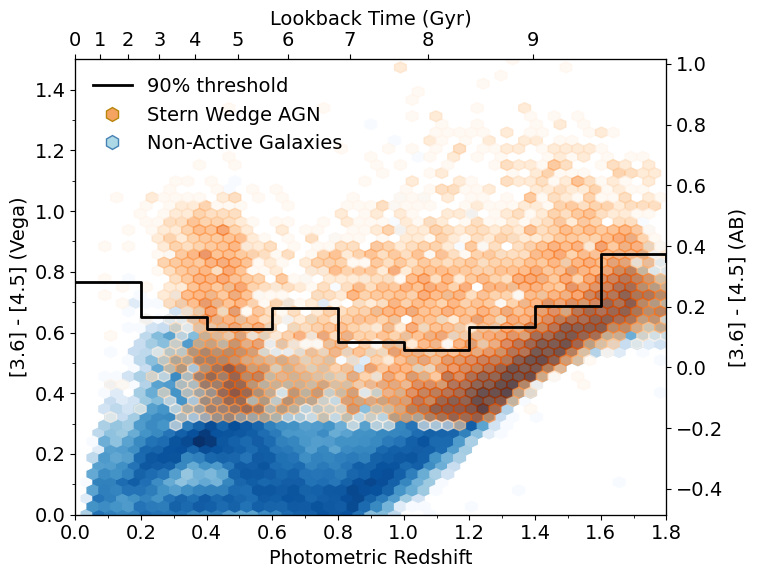

In [9]:
# Make main plot only
z_bin_centers = np.diff(z_bins) + z_bins[:-1]
fig, ax = plt.subplots(figsize=(7.8, 6))

# Main panel plot
ax.hexbin(non_agn['PHOT_Z'], non_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 1.8, 0., 1.5), cmap='Blues', bins='log', mincnt=1)
ax.hexbin(stern_agn['PHOT_Z'], stern_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 1.8, 0., 1.5), cmap='Oranges', bins='log', mincnt=1, alpha=0.6)
ax.step(z_bins[:-1], purity_90_color, where='post', lw=2, c='k', label='90% threshold')
# ax.step(z_bins[:-1], purity_92_color, where='post', lw=2, label='92% threshold')
# ax.step(z_bins[:-1], purity_95_color, lw=2, where='post', label='95% threshold')
# ax.axhline(y=0.7, color='k', lw=2, ls='--', label=r'$[3.6] - [4.5] \geq 0.7$')

# Main panel axes and legend
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
handles, labels = ax.get_legend_handles_labels()
handles.extend([Line2D([0], [0], marker='h', color='w', markerfacecolor='sandybrown', markeredgecolor='darkgoldenrod', markersize=10),
                Line2D([0], [0], marker='h', color='w', markerfacecolor='lightblue', markeredgecolor='steelblue', markersize=10)])
labels.extend(['Stern Wedge AGN', 'Non-Active Galaxies'])
plt.legend(handles, labels, frameon=False)
ax.set(xlabel='Photometric Redshift', ylabel='[3.6] - [4.5] (Vega)', ylim=[0, 1.5], xlim=[0, 1.8])

# Main panel lookback time top axis
min_z, max_z = ax.get_xlim()
ax1 = ax.twiny()
lb_time = np.arange(cosmo.lookback_time(min_z).value, cosmo.lookback_time(max_z).value) * u.Gyr
lb_time_ticks = [z_at_value(cosmo.lookback_time, lbt) for lbt in lb_time[1:]]
lb_time_ticks.insert(0, 0)
ax1.set_xticks(lb_time_ticks)
ax1.set_xticklabels([f'{lbt:g}' for lbt in lb_time.value])
ax1.set(xlabel='Lookback Time (Gyr)', xlim=[min_z, max_z])

# Add AB colors on right axis
min_color, max_color = ax.get_ylim()
ax2 = ax.twinx()
ax2.set(ylabel='[3.6] - [4.5] (AB)', ylim=[min_color+2.779-3.264, max_color+2.779-3.264])

fig.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SDWFS_AGN_color-redshift_color_thresholds_publication.pdf')

[Text(0.5, 0, '$N$'), None]

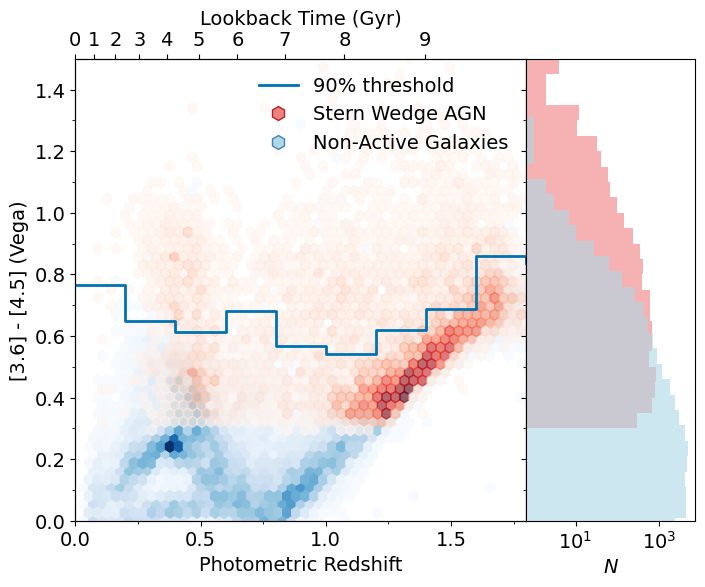

In [10]:
# Make plot with side histogram
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(8, 3), wspace=0)

# Main panel plot
ax = fig.add_subplot(gs[0])
ax.hexbin(non_agn['PHOT_Z'], non_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 1.8, 0., 1.5),
          cmap='Blues', bins=None, mincnt=1)
ax.hexbin(stern_agn['PHOT_Z'], stern_agn['CH1_CH2_COLOR'], gridsize=50, extent=(0., 1.8, 0., 1.5), cmap='Reds',
          bins=None, mincnt=1, alpha=0.6)
ax.step(z_bins[:-1], purity_90_color, where='post', lw=2, label='90% threshold')
# ax.step(z_bins[:-1], purity_92_color, where='post', lw=2, label='92% threshold')
# ax.step(z_bins[:-1], purity_95_color, where='post', lw=2, label='95% threshold')
# ax.axhline(y=0.7, color='k', lw=2, ls='--', label=r'$[3.6] - [4.5] \geq 0.7$')

# Main panel axes and legend
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
handles, labels = ax.get_legend_handles_labels()
handles.extend([Line2D([0], [0], marker='h', color='w', markerfacecolor='lightcoral', markeredgecolor='firebrick',
                       markersize=10),
                Line2D([0], [0], marker='h', color='w', markerfacecolor='lightblue', markeredgecolor='steelblue',
                       markersize=10)])
labels.extend(['Stern Wedge AGN', 'Non-Active Galaxies'])
plt.legend(handles, labels, frameon=False)
ax.set(xlabel='Photometric Redshift', ylabel='[3.6] - [4.5] (Vega)', ylim=[0, 1.5], xlim=[0, 1.8])

# Main panel lookback time top axis
min_z, max_z = ax.get_xlim()
ax1 = ax.twiny()
lb_time = np.arange(cosmo.lookback_time(min_z).value, cosmo.lookback_time(max_z).value) * u.Gyr
lb_time_ticks = [z_at_value(cosmo.lookback_time, lbt) for lbt in lb_time[1:]]
lb_time_ticks.insert(0, 0)
ax1.set_xticks(lb_time_ticks)
ax1.set_xticklabels([f'{lbt:g}' for lbt in lb_time.value])
ax1.set(xlabel='Lookback Time (Gyr)', xlim=[min_z, max_z])

# Side panel histogram
ax_hist = fig.add_subplot(gs[1], sharey=ax)
ax_hist.tick_params(axis='y', labelleft=False)
binwidth = 0.05
bins_nonAGN = np.arange(non_agn['CH1_CH2_COLOR'].min(), non_agn['CH1_CH2_COLOR'].max() + binwidth, binwidth)
bins_AGN = np.arange(stern_agn['CH1_CH2_COLOR'].min(), stern_agn['CH1_CH2_COLOR'].max() + binwidth, binwidth)
ax_hist.hist(stern_agn['CH1_CH2_COLOR'][(stern_agn['PHOT_Z'] > min_z) & (stern_agn['PHOT_Z'] < max_z)], bins=bins_AGN,
             orientation='horizontal', color='lightcoral', alpha=0.6)
ax_hist.hist(non_agn['CH1_CH2_COLOR'][(non_agn['PHOT_Z'] > min_z) & (non_agn['PHOT_Z'] < max_z)], bins=bins_nonAGN,
             orientation='horizontal', color='lightblue', alpha=0.6)
# ax_hist.axhline(y=0.7, color='k', linewidth=2)
ax_hist.set(xlabel=r'$N$', xscale='log')

# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SDWFS_AGN_color-redshift_color_thresholds_with_hist_publication.pdf')